# Обогащение золота.

Необходимо подготовить прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. На входе данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from scipy import stats as st

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# gridsearch
from sklearn.model_selection import GridSearchCV

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

Данные находятся в трёх файлах:
* gold_recovery_train.csv — обучающая выборка
* gold_recovery_test.csv — тестовая выборка
* gold_recovery_full.csv — исходные данные

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

In [2]:
# грузим данные
try:
    recovery_train_data = pd.read_csv("G:/Projects/praktikum/datasets/gold_recovery_train.csv")
    recovery_test_data = pd.read_csv("G:/Projects/praktikum/datasets/gold_recovery_test.csv")
    recovery_full_data = pd.read_csv("G:/Projects/praktikum/datasets/gold_recovery_full.csv")
except:
    recovery_train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
    recovery_test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
    recovery_full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
recovery_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
recovery_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
recovery_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Данные загружены. Видно большое кол-во пропущенных значений, данные довольно "грязные".

# 2. Подготовка данных

## 2.1 Проверка рассчёта эффективности обогащения

Для рассчёта параметра recovery будем использовать только те измерения, где этот параметр уже приведён.

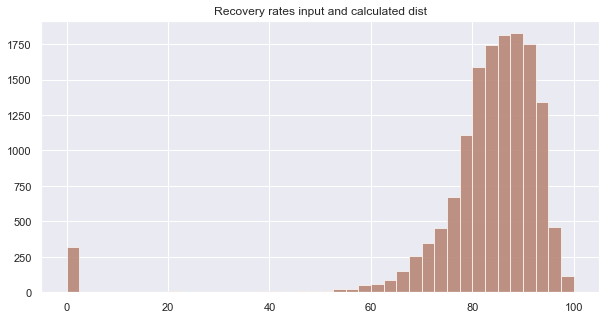

Mean absolute error = 9.444891926100695e-15


In [6]:
# посмотрим, где в данных посчитан параметр recovery
recovery_train = recovery_train_data['rougher.output.recovery'].dropna()

# изымаем данные для рассчётов, опираясь на индексы уже известных значений
c = recovery_train_data.iloc[recovery_train.index]['rougher.output.concentrate_au'].dropna()
f = recovery_train_data.iloc[recovery_train.index]['rougher.input.feed_au'].dropna()
t = recovery_train_data.iloc[recovery_train.index]['rougher.output.tail_au'].dropna()

recovery_check = ((f-t)*c) / ((c-t)*f) * 100

# считаем MAE
mae_recovery_check = mean_absolute_error(recovery_train, recovery_check)

# гистограммы для оценки результата
ax = recovery_train.hist(bins=40, figsize=(10,5), alpha=0.6)
recovery_check.hist(ax=ax, alpha=0.6, bins=40)
plt.title('Recovery rates input and calculated dist')

plt.show()
print('Mean absolute error =', mae_recovery_check)

В целом значения получились почти равные. MAE стремиться к нулю.

Можно сделать вывод, что рассчёта эффективности обогащения в исходных данных проведён правильно.

<b>Антон:</b><br />
Верно! Я что-то запутался сначала с этими пропусками. Но если изначально фильтровать данные только по уже известным значениям recovery - всё получается! Спасибо!)

## 2.2 Анализ признаков, недоступных в тестовой выборке.

In [7]:
# посмотрим признаки, нгедоступные в тестовой выборке
missing_columns = []
for cols in recovery_train_data.columns:
    if cols not in recovery_test_data:
        missing_columns.append(cols)

In [8]:
missing_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют данные о выходе продуктов на разные этапах очистки\обогащения - отсутствуют практически все признаки с параметром .output. В том числе целевые.

Так же в тестовой сборке отсутствуют несколько признаков с вычислениями (.calculation).

Дополним тестовую выборку данными из полной выборки, т.к. признаки нам понадобятся в дальнейшем.

<b>Антон:</b><br />
Ох... Это было не очевидно из описания задания...<br/>
Это существенно меняет обучение моделей!) Вероятно, такая низкая ошибка в тестах у меня и получилась, что я использовал больше признаков, в том числе output, для обучения.<br/>
Ты заинтриговал меня, поэтому я переделал раздел с определением признаков и обучениями моделей "по требованиям Заказчика"))) 

## 2.3 Предобработка данных

Подготовим данные для дальнейшей работы.

Как упоминалось ранее, по условиям задания, соседние по времени параметры часто похожи. Так как в данных много пропусков, заполним пропуски методом ffill. 

In [9]:
recovery_train_data = recovery_train_data.fillna(method='ffill')
recovery_test_data = recovery_test_data.fillna(method='ffill')
recovery_full_data = recovery_full_data.fillna(method='ffill')
recovery_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22716 non-null  float64
 2   final.output.concentrate_pb                         22716 non-null  float64
 3   final.output.concentrate_sol                        22716 non-null  float64
 4   final.output.concentrate_au                         22716 non-null  float64
 5   final.output.recovery                               22716 non-null  float64
 6   final.output.tail_ag                                22716 non-null  float64
 7   final.output.tail_pb                                22716 non-null  float64
 8   final.output.tail_sol                               22716 non-null  float64


<b>Антон:</b><br />
Николай, ты закомментил эту ячейку с заполнениями пропусков. Забыл убрать #? Или ...?

Проверим, есть ли в данных не корректные значения долей. Для этого взглянем на кол-во значений меньше 0 и больше 100ю Для параметров .output не должно быть таких значений.

In [10]:
# считаем для каждого столбца кол-во значений меньше нуля и больше 100
for cols in recovery_full_data.columns:
    try:
        sub_zeros = recovery_full_data[recovery_full_data[cols] < 0][cols]
        up_hundred = recovery_full_data[recovery_full_data[cols] > 100][cols]
        print(cols, sub_zeros.shape[0], up_hundred.shape[0])
    except:
        print(cols, '---')

date ---
final.output.concentrate_ag 0 0
final.output.concentrate_pb 0 0
final.output.concentrate_sol 0 0
final.output.concentrate_au 0 0
final.output.recovery 0 0
final.output.tail_ag 0 0
final.output.tail_pb 0 0
final.output.tail_sol 0 0
final.output.tail_au 0 0
primary_cleaner.input.sulfate 0 17208
primary_cleaner.input.depressant 0 0
primary_cleaner.input.feed_size 0 0
primary_cleaner.input.xanthate 0 0
primary_cleaner.output.concentrate_ag 0 0
primary_cleaner.output.concentrate_pb 0 0
primary_cleaner.output.concentrate_sol 0 0
primary_cleaner.output.concentrate_au 0 0
primary_cleaner.output.tail_ag 0 0
primary_cleaner.output.tail_pb 0 0
primary_cleaner.output.tail_sol 0 0
primary_cleaner.output.tail_au 0 0
primary_cleaner.state.floatbank8_a_air 0 21594
primary_cleaner.state.floatbank8_a_level 22716 0
primary_cleaner.state.floatbank8_b_air 0 21597
primary_cleaner.state.floatbank8_b_level 22716 0
primary_cleaner.state.floatbank8_c_air 0 21522
primary_cleaner.state.floatbank8_c_level

## Выводы:
Были загружены и проанализированы исходные данные.

В данных обнаружено большое кол-во пропущенных значений. Для их заполнения использовался метод ffill, заполняющий пропуски близкими по расположению данных.

Так же были проанализированы значения парметров. Выбросов в ходе анализа не обнаружено. Данные готовы для дальнейшей обработки.

# 3. Анализ данных

## 3.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Проанализируем концентрацию металов на выходе различных этапов.

In [11]:
# функция на входе получает метал, считает средние значения концентрации на каждом этапе и строит ящики значений для каждого этапа
def metals_conc_difs(metal):
    # собираеми датасет с нужными значениями
    output_cols = ['rougher.input.feed_{}'.format(metal), 'rougher.output.concentrate_{}'.format(metal), 'primary_cleaner.output.concentrate_{}'.format(metal), 'final.output.concentrate_{}'.format(metal)]
    concentrates = recovery_full_data[output_cols]
    
    # считаем средние значения
    conc_means = []
    for each in output_cols:
        conc_means.append(concentrates[each].mean())
                   
    # строим ящики с усами для значений каждого этапа
    boxplot = concentrates.boxplot(column=output_cols, figsize=(15,5))
    boxplot.set_title('{} concentrates outputs'.format(metal))

    print('{} concentrate means:'.format(metal))
    print('Input frac:', round(conc_means[0],2))
    print('Rogher output frac:', round(conc_means[1], 2))
    print('Prim.cleaner output frac:', round(conc_means[2], 2))
    print('Final output frac:', round(conc_means[3], 2))
    plt.show()

ag concentrate means:
Input frac: 8.04
Rogher output frac: 10.85
Prim.cleaner output frac: 7.67
Final output frac: 4.77


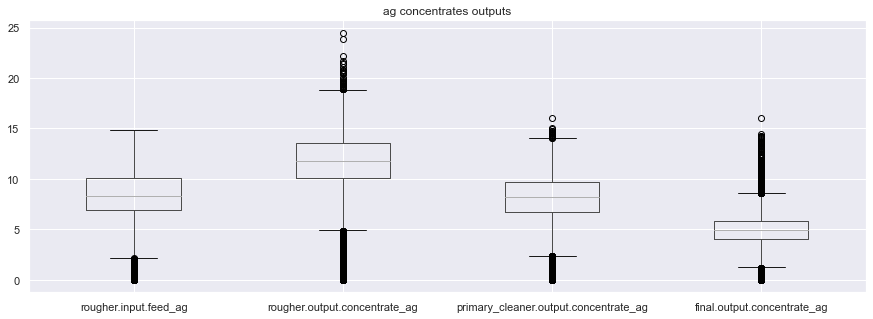

In [12]:
# серебро
metals_conc_difs('ag')

pb concentrate means:
Input frac: 3.28
Rogher output frac: 6.89
Prim.cleaner output frac: 8.81
Final output frac: 9.07


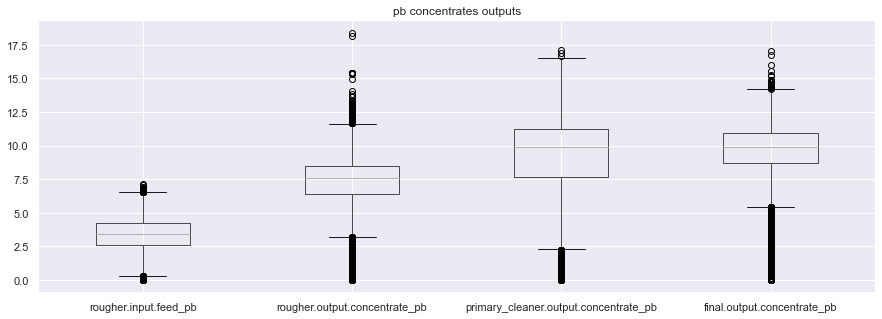

In [13]:
# свинец
metals_conc_difs('pb')

au concentrate means:
Input frac: 7.55
Rogher output frac: 17.83
Prim.cleaner output frac: 29.12
Final output frac: 39.89


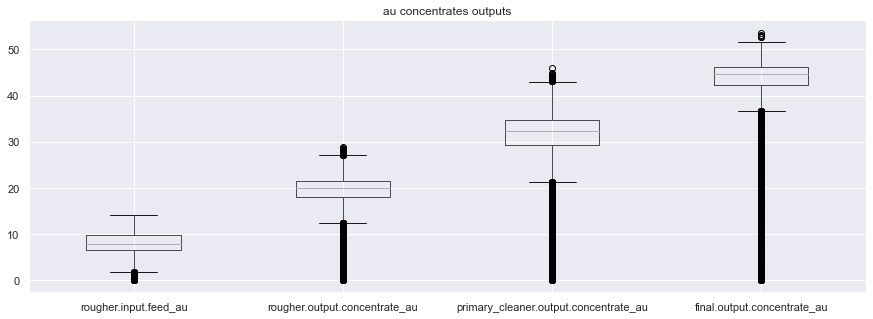

In [14]:
# золото
metals_conc_difs('au')

### Выводы:

1. Конецентрация серебра увеличивается после грубой обработки, и после снижается на каждом из этапов очистки.
2. Концентрация свинца повышается после каждого этапа обработке. Однако на этапах очистки она остаётся более-менее на обном уровне.1
3. Концентрация золота уверенно растёт на каждом этапе обогащения. Так и должно быть)

## 3.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Для сравнения данных о размерах гранул сырья (rougher.input.feed_size), построим гистограммы и посмотрим данные о распределении этих значений в тестовой и обучающих выборках.

(0.0, 150.0)

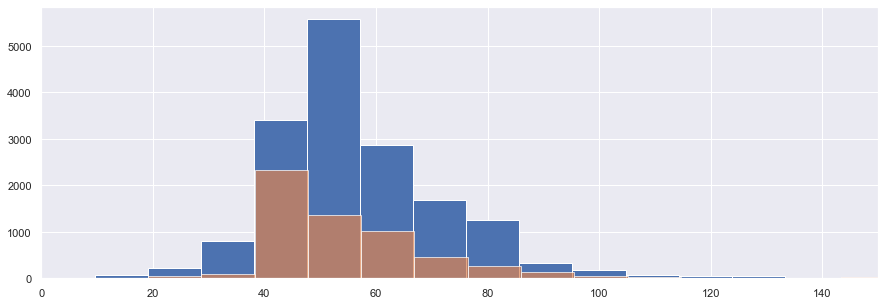

In [15]:
# гистограмма распределения величин
ax=recovery_train_data['rougher.input.feed_size'].hist(bins=50, figsize=(15,5))
recovery_test_data['rougher.input.feed_size'].hist(ax=ax, bins=50, alpha=0.7)
plt.xlim([0,150])

In [16]:
# информация о распределении в тренировочном наборе
recovery_train_data['rougher.input.feed_size'].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [17]:
# в тестовом наборе
recovery_test_data['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Несмотря на разницу в кол-ве значений в двух сборках, распределение значений размеров гранул сырья для тестовой и обучающей выборках сравнимы, отличаются не сильно: средние значения равны 56 и 60 соответственно.

## 3.3 Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Исследуем суммарную концентрацию всех веществ на разных стадия. Аомалии в этих значения помогут нам обнаружить аномалии в данных в целом.

In [18]:
# функция считает суммы для стадий, записывает их в датафрейм. Еще строит красивые графики
def bad_zeros(data):
    # создаём датафрейм с суммарными значениями концентраций всех веществ
    sum_concentrate = pd.DataFrame()
    sum_concentrate['input'] = data['rougher.input.feed_ag'] + data['rougher.input.feed_pb'] + data['rougher.input.feed_au'] + data['rougher.input.feed_sol']
    sum_concentrate['rougher_output'] = data['rougher.output.concentrate_ag'] + data['rougher.output.concentrate_pb'] + data['rougher.output.concentrate_au'] + data['rougher.output.concentrate_sol']
    sum_concentrate['final_output'] = data['final.output.concentrate_ag'] + data['final.output.concentrate_pb'] + data['final.output.concentrate_au'] + data['final.output.concentrate_sol']
    
    # строим гистограммы значений
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(20,5)
    sum_concentrate.plot(ax=ax[0], kind='hist', y='input', bins=30, color='g')
    sum_concentrate.plot(ax=ax[1], kind='hist', y='rougher_output', bins=30)
    sum_concentrate.plot(ax=ax[2], kind='hist', y='final_output', bins=30, color='r')
    fig.suptitle('Concentrates summary distribution', fontsize=16)
    plt.show()
    
    return sum_concentrate

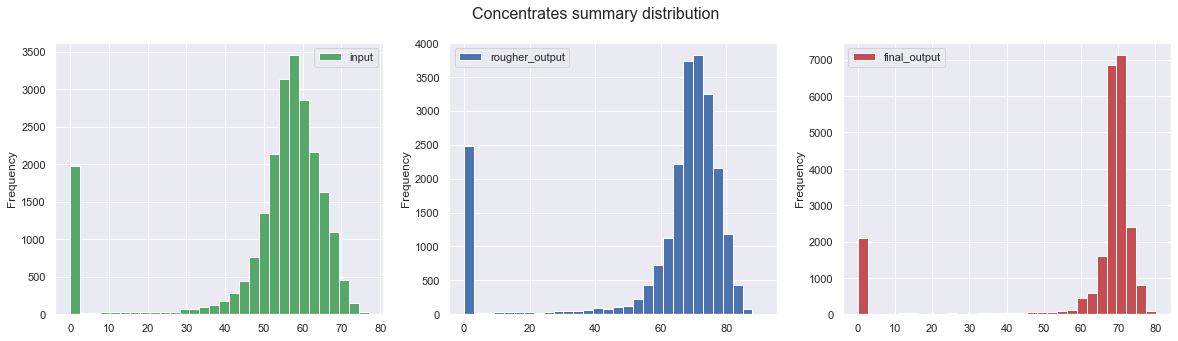

In [19]:
# применяем функцию к полным данным
sum_conc_full = bad_zeros(recovery_full_data)

В исследуемых данных обнаружены аномалии в виде большого кол-ва около-нулевых значений.

С точки зрения процесса обогащения это может быть нормально - оборудование разных этапов может отключаться (на тех.обслуживание или по другим причинам), хотя данные при этом продолжают сниматься. 
Так же, любое оборудование имеет погрешность.

С точки зрения целей проекта, нулевые данные могут внести ошибки в процесс машинного обучения, поэтому от них необходимо избавиться.

In [20]:
# функция берет на вход потолочное значение и возвращает перечень временных индексов, для которых все значения по этапу ниже заданного
def get_bad_index(ceil):
    bad_index = pd.Series()
    # плохие индексы при загрузке в rougher
    bad_index = bad_index.append((recovery_full_data[(recovery_full_data['rougher.input.feed_ag'] <= 0)
        & (recovery_full_data['rougher.input.feed_pb'] <= 0)
        & (recovery_full_data['rougher.input.feed_au'] <= 0)
        & (recovery_full_data['rougher.input.feed_sol'] <= 0)])['date'])

    # плохие индексы в выдаче из rougher
    bad_index = bad_index.append((recovery_full_data[(recovery_full_data['rougher.output.concentrate_ag'] <= 0) 
        & (recovery_full_data['rougher.output.concentrate_pb'] <= 0)
        & (recovery_full_data['rougher.output.concentrate_au'] <= 0)
        & (recovery_full_data['rougher.output.concentrate_sol'] <= 0)])['date'])

    # плохие индексы в финальной выдаче
    bad_index = bad_index.append((recovery_full_data[(recovery_full_data['final.output.concentrate_ag'] <= 0) 
        & (recovery_full_data['final.output.concentrate_pb'] <= 0)
        & (recovery_full_data['final.output.concentrate_au'] <= 0)
        & (recovery_full_data['final.output.concentrate_sol'] <= 0)])['date'])
    return bad_index

In [21]:
# удаляем нулевые значения, применив функцию с потолком 0
bad_index = get_bad_index(0)
# сохраним отфильтрованные данные
train_data = recovery_train_data.query('date not in @bad_index')
test_data = recovery_test_data.query('date not in @bad_index')

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


После отброса нулевых значений, проанализируем полученные данные. Предположим, что средняя погрешность измерений составляет около 5%. Таким образом, нулевым значением с учетом погрешности будет 0+-5%.

Чтобы оценить величину погрешности в долях, посмотрим на 5% квантили данных.

In [22]:
# интересующие нас столбцы
cols_for_look = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_sol', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_sol']

# смотрим на 5% квантиль
for each in cols_for_look:
    print(each, '5% квантиль:', train_data[each].quantile(0.05))

rougher.input.feed_ag 5% квантиль: 5.773636903163368
rougher.input.feed_pb 5% квантиль: 1.3622408523410559
rougher.input.feed_au 5% квантиль: 4.134270917179479
rougher.input.feed_sol 5% квантиль: 20.983857241047748
rougher.output.concentrate_ag 5% квантиль: 6.791024352217166
rougher.output.concentrate_pb 5% квантиль: 3.9599638313583947
rougher.output.concentrate_au 5% квантиль: 11.331508594052405
rougher.output.concentrate_sol 5% квантиль: 13.320889125556992
final.output.concentrate_ag 5% квантиль: 3.1746835549277614
final.output.concentrate_pb 5% квантиль: 6.510743965294626
final.output.concentrate_au 5% квантиль: 32.25766670039221
final.output.concentrate_sol 5% квантиль: 2.4628880413420267


Минимальное значение 5% квантиля для доли вещества без нулевых значений равно 1.4. Примем это за минимальный порог валидных значений.

In [23]:
# получим индексы, где значения долей вещества меньше определённого порога валидности
bad_index = get_bad_index(1.4)
# повторно отфильтруем данные
train_data = recovery_train_data.query('date not in @bad_index').reset_index(drop=True)
test_data = recovery_test_data.query('date not in @bad_index').reset_index(drop=True)
full_data = recovery_full_data.query('date not in @bad_index').reset_index(drop=True)

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


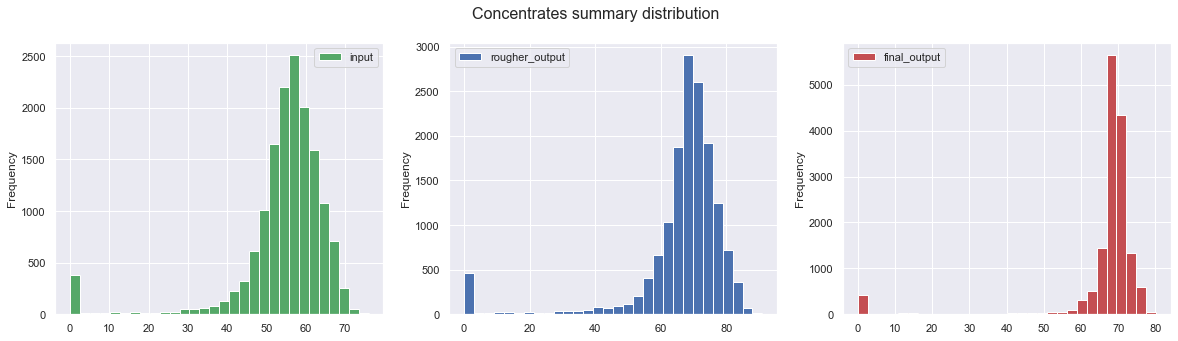

In [24]:
# посмотрим распределение сумм по отфильтрованным данным
bad_train = bad_zeros(train_data)

Всё равно заметны около-нулевые значения. Но зато это могут быть вполне валидные данные. 

### Выводы
Были изучены концентрации различных веществ на разных этапа технологического процесса. Данные проанализированы и проверены на валидность. Аномалий не обнаружено.

Также были изучены размеры гранул сырья в тестовой и обучающей сборках. Средние размеры гранул 56(std=22) и 60(std=30) для тестовой и обучающей соответственно. Распределения можно оценить как близкие по значениям.

Были проанализированы суммы долей различных веществ в сырье, черновом и финальном концентратах. Были обнаружены аномалии в виде нулевых и околонулевых значений. Такие значения могут быть получены при особенностях тех.процесса или погрешностях оборудования. Для минимизации ошибок при обучении машинных моделей, был определён минимальный порог доли вещества (1.3 %). Данные для обучения и тестирования моделей были соответсвующим образом отфильтрованы.

# 4. Построение моделей

## 4.1 Симметричная средняя абсолютная процентная ошибка (sMAPE)

Для скорринга моделей будет использоваться симметричная средняя абсолютная процентная ошибка.
Напишем функцию для рассчёта sMAPE.

In [25]:
# функция для рассчёта sMAPE
def smape(targ, pred):
    smape_df = pd.DataFrame()
    smape_df['dif'] = abs(targ - pred)
    smape_df['means'] = (abs(targ) + abs(pred))/2
    smape_df['div'] = (smape_df['dif'] / smape_df['means'])*100
    n = len(targ)
    div_sum = smape_df['div'].sum()
    smape = div_sum / n
    return float(smape)

In [26]:
# создаём собственный скоринг на основе этой функции
smape_score = make_scorer(smape, greater_is_better=False)

In [27]:
# функция для подсчёта окончательного sMAPE на основе скоров моделей флотации и очистки
def smape_final(mape_rougher, mape_final):
    score = (mape_rougher*0.25) + (mape_final*0.75)
    return float(score)

## 4.2 Обучение и валидация моделей

Т.к. процессы флотации и очистки последовательны, они имеют независимые признаки. Поэтому необходимо подготовить отдельные наборы признаков для каждого процесса и обучить на них свою модель.

Таким образом, будут строится две модели каждого вида. Одна для процесса флотации(целевой признак - rougher.output.recovery), и одна для процесса очистки(целевой признак - final.output.recovery).

### 4.2.1 Подготовка признаков

Сначала подготовим признаки для обучения моделей.

Для обучения, по условиям Заказчика, используются только признаки из тестовой выборки.

In [28]:
train_cols = recovery_test_data.columns
train_cols

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [29]:
# выделим признаки для процесса флотации
# для обучения не используются столбцы с вычислениями(calculations) и состояниями(state)
rougher_train_cols = []
for cols in test_data.columns:
    if 'rougher' in str(cols):
        if 'state' not in str(cols):
            if 'calculation' not in str(cols):
                rougher_train_cols.append(cols)
rougher_train_cols

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [30]:

# обучающий и целевой признаки для обучающей выборки
rougher_train_features = train_data[rougher_train_cols]
rougher_train_target = train_data['rougher.output.recovery']

# обучающий и целевой признаки для тестовой выборки
test_dates = test_data['date']
rougher_test_features = test_data[rougher_train_cols]
rougher_test_target = recovery_full_data.query('date in @test_dates')['rougher.output.recovery']

print('Rougher')
print('train features shape:', rougher_train_features.shape)
print('train target shape:',rougher_train_target.shape)
print('test features shape:', rougher_test_features.shape)
print('test target shape:', rougher_test_target.shape)

Rougher
train features shape: (15128, 10)
train target shape: (15128,)
test features shape: (5292, 10)
test target shape: (5292,)


Теперь выделим признаки процесса очистки. 
По технологическому процессу, на вход очистки подаётся концентрат, поэтому для обучения моделей очистки мы также будем учитывать признаки rougher.output.concentrate_*. 

In [31]:
# признаки процесса очистки
final_train_cols = []
for cols in test_data.columns:
    if 'rougher' not in str(cols):
        if 'state' not in str(cols):
            if 'calculation' not in str(cols):
                final_train_cols.append(cols)

# добавим признаки концентратов флотации
#for each in ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']:
#    final_train_cols.append(each)

final_train_cols

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate']

In [32]:
# обучающий и целевой признаки для обучающей выборки
final_train_features = train_data[final_train_cols].drop(['date'], axis=1)
final_train_target = train_data['final.output.recovery']

# обучающий и целевой признаки для тестовой выборки
final_test_features = test_data[final_train_cols].drop(['date'], axis=1)
final_test_target = recovery_full_data.query('date in @test_dates')['final.output.recovery']


print('Final')
print('train features shape:', final_train_features.shape)
print('train target shape:', final_train_target.shape)
print('test features shape:', final_test_features.shape)
print('test target shape:', final_test_target.shape)

Final
train features shape: (15128, 4)
train target shape: (15128,)
test features shape: (5292, 4)
test target shape: (5292,)


Признаки для обучения и тестирования моделей готовы. Переходим к моделированию.

Для поиска оптимальных гиперпараметров моделей TreeRegressor и RFRegressor будет использоваться функция GridSearchCV.
Данная функция позволяет перебирать гиперпараметры, автоматически валидировать их с помощью кросс-валидации. Кроме того, функция позволяет переопределить функцию скоринга - мы будем использовать нашу sMAPE.

### 4.2.2 Константная модель

Для оценки адекватности моделей, посмотрим на метрики константной модели - которая предсказывает только медианные значения целевых признаков.

In [33]:
# берем медианы целевого признака обучающей выборки
rougher_recovery_median = rougher_train_target.median()
final_recovery_median = final_train_target.median()

# строим константные целевые признаки
rougher_target_const = pd.Series(rougher_recovery_median, index=rougher_test_target.index)
final_target_const = pd.Series(final_recovery_median, index=final_test_target.index)

#считаем метрики для константной модели
smape_const_rougher = smape(rougher_test_target, rougher_target_const)
smape_const_final = smape(final_test_target, final_target_const)

print('sMAPE for rougher const. model:', smape_const_rougher)
print('sMAPE for cleaner const. model:', smape_const_final)
print('Final sMAPE for const. models:', smape_final(smape_const_rougher, smape_const_final))

sMAPE for rougher const. model: 5.327571034951264
sMAPE for cleaner const. model: 8.538475799902201
Final sMAPE for const. models: 7.735749608664467


Финальный скор sMAPE для константной модели получился 7.73 %.

### 4.2.2 RandomForestRegressor

Подбираем оптимальные гиперпараметры, ориентируясь на минимизацию SMAPE.

In [34]:
# функция для обучения gridsearch, возвращает лучший скор smape и параметры
# WARNING: это может считаться дооолго
def RFR_grid(feat, targ):
    estimator = RandomForestRegressor(random_state=112211)
    param_grid = { 
            "n_estimators"      : [5,10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth" : [i for i in range(5,21,5)],
            "min_samples_leaf" : [1, 4, 8],
            "min_samples_split" : [2,4,8,10,12],
            "bootstrap": [True, False],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring=smape_score)
    rfr_grid.fit(feat, targ)
    
    return rfr_grid.best_score_, rfr_grid.best_params_

In [35]:
# применяем функцию к модели флотации
RFR_grid(rougher_train_features, rougher_train_target)

(-7.466190738016744,
 {'bootstrap': True,
  'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 10})

In [52]:
# Обучаем модель для флотации с найденными параметрами
model_rougher = RandomForestRegressor(n_estimators=30, max_features='sqrt', min_samples_split=2, bootstrap=True, max_depth=20, min_samples_leaf=8, random_state=112211)
model_rougher.fit(rougher_train_features, rougher_train_target)

# тестируем модель
pred = model_rougher.predict(rougher_test_features)
smape_rougher = smape(rougher_test_target, pred)
print('Rougher sMAPE-score:', smape_rougher)

Rougher sMAPE-score: 4.6119312465647


In [37]:
# гридсерч для процесса очистки
RFR_grid(final_train_features, final_train_target)

(-10.715770849436598,
 {'bootstrap': False,
  'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 5})

In [55]:
model_clean = RandomForestRegressor(n_estimators=5, max_features='sqrt', min_samples_split=2, bootstrap=False, max_depth=5, min_samples_leaf=1, random_state=112211)
model_clean.fit(final_train_features, final_train_target)
pred = model_clean.predict(final_test_features)

smape_clean = smape(final_test_target, pred)
print('Cleaner sMAPE-score:', smape_clean)

Cleaner sMAPE-score: 7.499540055557234


In [56]:
# считаем финальный скор
print('Final sMAPE:', smape_final(smape_rougher, smape_clean))

Final sMAPE: 6.777637853309101


Итоговая средняя абсолютная ошибка для модели случайного леса получилась sMAPE = 6.77%. 

### 4.2.3 DecicionTreeRegressor

Для моделей дерева проходим ту же процедуру, что и для леса - ищем оптимальные параметры, ориентируясь на sMAPE.

In [40]:
# функция гридсерч для дерева
def DTC_grid(feat, targ):
    estimator = DecisionTreeRegressor(random_state=112211)
    param_grid = { 
            "max_depth" : [i for i in range(1,20,2)],
            "min_samples_leaf" : [i for i in range(1,20,2)],
            "min_samples_split" : [2,4,8,10,12],
            "max_features"      : ["auto", "sqrt", "log2"],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring=smape_score)
    rfr_grid.fit(feat, targ)
    
    return rfr_grid.best_score_, rfr_grid.best_params_

In [41]:
# Ищем параметры для флотации
DTC_grid(rougher_train_features, rougher_train_target)

(-7.913666678371029,
 {'max_depth': 3,
  'max_features': 'auto',
  'min_samples_leaf': 19,
  'min_samples_split': 2})

In [57]:
# тестируем модель флотации
model = DecisionTreeRegressor(max_depth=3, max_features='auto', min_samples_split=2, min_samples_leaf=19, random_state=112211)
model.fit(rougher_train_features, rougher_train_target)
pred = model.predict(rougher_test_features)

smape_rougher = smape(rougher_test_target, pred)
print('Rougher sMAPE-score:', smape_rougher)

Rougher sMAPE-score: 5.445838537427789


In [43]:
# ищем параметры для очистки
DTC_grid(final_train_features, final_train_target)

(-10.87785081090036,
 {'max_depth': 3,
  'max_features': 'auto',
  'min_samples_leaf': 7,
  'min_samples_split': 2})

In [58]:
# тестируем модель очистки
model = DecisionTreeRegressor(max_depth=3, max_features='auto', min_samples_split=2, min_samples_leaf=7, random_state=112211)
model.fit(final_train_features, final_train_target)
pred = model.predict(final_test_features)

smape_clean = smape(final_test_target, pred)
print('Cleaner sMAPE-score:', smape_clean)

Cleaner sMAPE-score: 7.656515753260873


In [59]:
# считаем финальный скор
print('Final sMAPE:', smape_final(smape_rougher, smape_clean))

Final sMAPE: 7.103846449302602


Тоже неплохо.
Итоговая средняя абсолютная ошибка для модели дерева получилась sMAPE = 7.10%. 

### 4.2.4 LinearRegression

Для линейной регрессии параметры искать не будем. Просто обучим и протестируем модели.

In [60]:
# обучаем модель для флотации
model = LinearRegression()
model.fit(rougher_train_features, rougher_train_target)

#тестируем модель 
pred = model.predict(rougher_test_features)
smape_rougher = smape(rougher_test_target, pred)
print('Rougher sMAPE-score:', smape_rougher)

Rougher sMAPE-score: 5.00722474849361


In [61]:
# обучаем модель для очистки
model = LinearRegression()
model.fit(final_train_features, final_train_target)

# тестируем модель
pred = model.predict(final_test_features)
smape_clean = smape(final_test_target, pred)
print('Cleaner sMAPE-score:', smape_clean)

Cleaner sMAPE-score: 8.108270258578171


In [62]:
# считаем финальный скор
print('Final sMAPE:', smape_final(smape_rougher, smape_clean))

Final sMAPE: 7.33300888105703


Ну вот и что-то среднее.
Итоговая средняя абсолютная ошибка для модели линейной регрессии получилась sMAPE = 7.33%. 

## Выводы
Были обучены и проанализированы модели машинного обучения отдельно для процесса флотации и отдельно для процесса очистки.
Полученные метрики для разных типов моделей:
* RandomForestRegressor: sMAPE = 6.77%
* DecisionTreeRegressor: sMAPE = 7.01%
* LinearRegression: sMAPE = 7.33%

# 5. Выводы

Целью данной работы было построение прототипа модели машинного обучения, для предсказывания коэффициента восстановления золота из золотосодержащей руды. На входе данные с параметрами добычи и очистки.

Данные были загружены, проанализированы и обработаны. Обнаруженные пропуски в данных были заполнены методом 'ffill'.

Были изучены концентрации различных веществ на разных этапа технологического процесса. Данные проанализированы и проверены на валидность. Аномалий не обнаружено.
Также были изучены размеры гранул сырья в тестовой и обучающей сборках. Средние размеры гранул 56(std=22) и 60(std=30) для тестовой и обучающей соответственно. Распределения можно оценить как близкие по значениям.

Были проанализированы суммы долей различных веществ в сырье, черновом и финальном концентратах. Были обнаружены аномалии в виде нулевых и околонулевых значений. Такие значения могут быть получены при особенностях тех.процесса или погрешностях оборудования. Для минимизации ошибок при обучении машинных моделей, был определён минимальный порог доли вещества (1.3 %). Данные для обучения и тестирования моделей были соответсвующим образом отфильтрованы.

Были построены различные модели машинного обучения для процесса флотации и процесса очистки. Для поиска оптимальных гиперпараметров использовался метод кросс-валидации на обучающей выборке.
Для оценки эффективности моделей использовался показатель симметричной средней абсолютной процентной ошибки (sMAPE). 
Итоговый sMAPE предсказаний двух моделей вычислялся по формуле: 
> sMAPE_final = sMAPE_rougher * 25% + sMAPE_cleaner * 75%

Итоговые метрики для разных типов моделей:
* Constant median model: sMAPE = 7.73 %
* RandomForestRegressor: sMAPE = 6.77%
* DecisionTreeRegressor: sMAPE = 7.01%
* LinearRegression: sMAPE = 7.33%

Таким образом, в качестве прототипа модели машинного обучения для целей работы, можно рекомендовать модель с лучшим скором - RandomForestRegressor.